This notebook is responsible for the training of the prediction of the SCP
codes model.

In [1]:
import pandas as pd
import numpy as np
import pickle
import wfdb
import os
from ast import literal_eval
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle

This dataset already includes a "strat_fold" column, already created by the
authors so the training data is already chosen by the authors and not randomly
and produce unwanted biases

In [2]:
# Dataset directory
ptb_dir = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"

# Whether to use the high or low resolution dataset
lowres = True
filetype = "filename_" + ("lr" if lowres else "hr")

# Loads the dataset with only the scp codes, strat fold and the filename
df = pd.read_csv(ptb_dir+"ptbxl_database.csv", index_col=["ecg_id"], usecols=["ecg_id", "scp_codes", "strat_fold", filetype])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21837 entries, 1 to 21837
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   scp_codes    21837 non-null  object
 1   strat_fold   21837 non-null  int64 
 2   filename_lr  21837 non-null  object
dtypes: int64(1), object(2)
memory usage: 682.4+ KB


In [3]:
df.head()

,scp_codes,strat_fold,filename_lr
ecg_id,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,records100/00000/00001_lr
2,"{'NORM': 80.0, 'SBRAD': 0.0}",2,records100/00000/00002_lr
3,"{'NORM': 100.0, 'SR': 0.0}",5,records100/00000/00003_lr
4,"{'NORM': 100.0, 'SR': 0.0}",3,records100/00000/00004_lr
5,"{'NORM': 100.0, 'SR': 0.0}",4,records100/00000/00005_lr


# Here we process the scp_codes into multilabel array

In [4]:
# Reads the scp csv file with the category as index
scp_df = pd.read_csv(ptb_dir+'scp_statements.csv', index_col=0)
scp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, NDT to TRIGU
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   description                    71 non-null     object 
 1   diagnostic                     44 non-null     float64
 2   form                           19 non-null     float64
 3   rhythm                         12 non-null     float64
 4   diagnostic_class               44 non-null     object 
 5   diagnostic_subclass            44 non-null     object 
 6   Statement Category             71 non-null     object 
 7   SCP-ECG Statement Description  71 non-null     object 
 8   AHA code                       37 non-null     float64
 9   aECG REFID                     23 non-null     object 
 10  CDISC Code                     13 non-null     object 
 11  DICOM Code                     13 non-null     object 
dtypes: float64(4), object(8)
memory usage: 7.2+ KB


In [5]:
# Convert json string as python object
scp_codes = df["scp_codes"].apply(lambda x : literal_eval(x))

def all_class():
  scp_length = len(scp_df)
  
  def create_multilabel(scpc: dict):
    # Create empty list with the length of scp
    res = [ 0 for _ in range(scp_length) ]
    
    for x, y in scpc.items():
      # If the confidence is below 50%, ditch it.
      # if (y > 50):
      # ! This part
      res[scp_df.index.get_loc(x)] = 1
      
    return res
  
  # For every scp_codes in df, we will create a new mutlilabel 2d array
  # New column
  df["result"] = scp_codes.apply(create_multilabel)
  
  return scp_length

def super_class():
  super_list = list(set(scp_df["diagnostic_class"]))
  super_list.remove(np.nan)
  scp_length = len(super_list)
  
  def create_superclass(scpc: dict):
    # Create empty list with the length of scp
    res = [ 0 for _ in range(scp_length) ]
    
    for x, y in scpc.items():
      # If the confidence is below 50%, ditch it.
      # if (y > 50):
      try:
        res[super_list.index(scp_df.loc[x]["diagnostic_class"])] = 1
        return res
      except ValueError:
        pass
      
    return res
  
  def create_superclass_label(scpc: dict):
    # Gets the superclass as string
    for x, y in scpc.items():
      try:
        diag = scp_df.loc[x]["diagnostic_class"]
        super_list.index(diag)
        return diag
      except ValueError:
        pass

    return None
  
  # For every scp_codes in df, we will create a new mutlilabel 2d array
  # New column
  df["result"] = scp_codes.apply(create_superclass)
  df["superclass"] = scp_codes.apply(create_superclass_label)
  
  return scp_length

# How many scp categories are there, and filters the data
scp_length = super_class()

df.head()

,scp_codes,strat_fold,filename_lr,result,superclass
ecg_id,,,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,records100/00000/00001_lr,"[0, 0, 0, 1, 0]",NORM
2,"{'NORM': 80.0, 'SBRAD': 0.0}",2,records100/00000/00002_lr,"[0, 0, 0, 1, 0]",NORM
3,"{'NORM': 100.0, 'SR': 0.0}",5,records100/00000/00003_lr,"[0, 0, 0, 1, 0]",NORM
4,"{'NORM': 100.0, 'SR': 0.0}",3,records100/00000/00004_lr,"[0, 0, 0, 1, 0]",NORM
5,"{'NORM': 100.0, 'SR': 0.0}",4,records100/00000/00005_lr,"[0, 0, 0, 1, 0]",NORM


In [6]:
def apply_superdiagnostic(scpc: dict):
  for x in scpc.keys():
    if scp_df.loc[x].diagnostic == 1.0:
      return True
  return False

super_bool = scp_codes.apply(apply_superdiagnostic)
super_bool.head()

ecg_id
1    True
2    True
3    True
4    True
5    True
Name: scp_codes, dtype: bool

In [7]:
from sklearn.preprocessing import StandardScaler

def get_standardizer(X):
  """Creates a standardizer
  Args:
      X (data): Must be raw
  Returns:
      StandardScaler: Scaler for dataset
  """
  if os.path.exists("datasetcache/standardizer.pkl"):
    return pickle.load(open("datasetcache/standardizer.pkl", "rb"))
  else:
    # Fit data to standardizer
    X_scaler = StandardScaler()
    X_scaler.fit(np.vstack(X).flatten()[:,np.newaxis].astype(float))
    
    # Save file
    pickle.dump(X_scaler, open("datasetcache/standardizer.pkl", "wb"), 4)
    
    return X_scaler

def apply_standardizer(X, ss):
    X_tmp = []
    for x in tqdm(X, "Applying PTB Standardizer"):
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp

def load_waveforms():
  """Loads the low or high resolution waveform data according to the `lowres`
  variable. The function iterates through the dataset and reads every file with
  rdsamp. Rdsamp returns a tuple (signal, meta), therefore to get the signal,
  [0] is needed after the function

  Returns:
      array: array of array with a dimension of `12x10*frequency` (100Hz / 500Hz
      depending on `lowres` variable)
  """
  data = None
  if os.path.exists("datasetcache/raw100.npy"):
    print("Loading saved raw dataset")
    data = np.load("datasetcache/raw100.npy", allow_pickle=True)
  else:
    # Load raw data
    # data = np.array([ wfdb.rdsamp(ptb_dir+f)[0] for f in tqdm(df[filetype], "Loading Waveform") ])
    data = np.array([ np.array([ pd.Series(wave) for wave in wfdb.rdsamp(ptb_dir+f)[0] ]) for f in tqdm(df[filetype], "Loading Waveform") ])
    pickle.dump(data, open("datasetcache/raw100.npy", "wb"), 4)

  # Scale data
  X_scaler = get_standardizer(data)
  data = apply_standardizer(data, X_scaler)
  
  # Transform data
  # Transpose
  data = np.transpose(data, (0, 2, 1)) # ! Transpose experiment

  return data, X_scaler

# Loads all the waveform data
X, X_scaler = load_waveforms()

Loading saved raw dataset


Applying PTB Standardizer: 100%|██████████| 21837/21837 [00:04<00:00, 5021.68it/s]


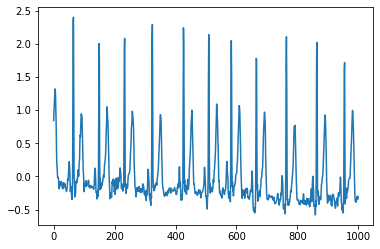

In [8]:
plt.clf()
plt.plot(X[10][0])
plt.savefig("datasetcache/test.png")
plt.show()

In [9]:
# Gets the Y of the dataset
Y = df
print(len(X), len(Y))

21837 21837


In [10]:
# Selects only super diagnostics
X, Y = X[super_bool], Y[super_bool]
print(len(X), len(Y))

21430 21430


In [11]:
# Splits the dataset into training and testing based on the strat_fold
# the dataset has graciously provided us

# Select which fold we want to use
test_fold = 10
train_sel = Y["strat_fold"] != test_fold
test_sel = Y["strat_fold"] == test_fold

# Splits the data
# !!!!!!!!! It is very, very important to use np.where for numpy arrays.
# !!!!!!!!! Lost almost 2 weeks because of this
X_tr = X[np.where(train_sel)]
Y_tr = np.array(Y[train_sel].result.to_list()).astype("float32")
Y_tr_l = Y[train_sel].superclass.to_numpy()

X_te = X[np.where(test_sel)]
Y_te = np.array(Y[test_sel].result.to_list()).astype("float32")
Y_te_l = Y[test_sel].superclass.to_numpy()

X_tr, Y_tr = shuffle(X_tr, Y_tr, random_state=35137)

print(len(X_tr), len(Y_tr), len(X_te), len(Y_te))
print(X_tr.shape, Y_tr.shape, X_te.shape, Y_te.shape)

19267 19267 2163 2163
(19267, 12, 1000) (19267, 5) (2163, 12, 1000) (2163, 5)


In [12]:
set(Y_tr_l), Y_tr_l[:30]

({'CD', 'HYP', 'MI', 'NORM', 'STTC'},
 array(['NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'MI',
        'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM',
        'NORM', 'STTC', 'NORM', 'NORM', 'STTC', 'NORM', 'STTC', 'NORM',
        'HYP', 'NORM', 'CD', 'NORM', 'NORM', 'NORM'], dtype=object))

## From this point, we can do the model training

In [13]:
# Load the model with tensorflow
import tensorflow as tf
from sklearn.linear_model import RidgeClassifierCV
import MiniRocket.minirocket_multivariate as MiniRocket
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [14]:
epochs = 10
batch_size = 64

def fit_efficient():
  """Efficient Net model fitting
  """
  from models import efficient_net
  model = efficient_net(scp_length)
  
  # Reshape the data so it can be inputted
  X_tr_r = X_tr.reshape((len(X_tr), 100, 120))
  X_te_r = X_te.reshape((len(X_te), 100, 120))
  
  model.fit(
    X_tr_r,
    Y_tr,
    epochs=epochs,
    batch_size=batch_size,
  )
  
  return model, X_te_r

def fit_inception():
  from Inception.inception import Classifier_INCEPTION as Inception
  from tensorflow.keras.callbacks import EarlyStopping, Callback
  
  in_model = Inception(
    "/inceptionres",
    X.shape[1:],
    scp_length,
  )
  model = in_model.model
  
  metrics = {}
  class MetricCollector(Callback):
    def on_epoch_end(self, epoch, logs={}):
        for key, val in logs.items():
          if key not in metrics:
            metrics[key] = [val]
          else:
            metrics[key].append(val)
  
  model.fit(
    X_tr,
    Y_tr,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[
      MetricCollector(),
      in_model.callbacks[0], # Get only reduce learning rate
    #   EarlyStopping( # Stop if the val loss is not that big
    #     monitor= "val_loss",
    #     min_delta = 0.1,
    #     patience = 3,
    #   )
    ],
  )
  
  return model, metrics

def fit_mini_rocket():
  X_tr32 = X_tr.astype("float32")
  params = MiniRocket.fit(X_tr32)
  X_tr_trans = MiniRocket.transform(X_tr32, params)
  
  Y_tr32 = Y_tr.astype("float32")
  
  print(Y_tr32[0])
  
  # IMPORTANT! In sklearn version 1.0.1, there is a bug in RidgeClassifierCV
  # that makes it unable to process multilabel targets, even though such
  # operations are said to be supported in the docs. To fix this, one must use
  # The nightly build of sklearn.
  classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
  classifier.fit(X_tr_trans, Y_tr32)
  
  return classifier, params

def fit_forest():
  from sktime.classification.interval_based import TimeSeriesForestClassifier
  from sktime.transformations.panel.compose import ColumnConcatenator
  
  # Combines multivariate data into one long one
  classifier = Pipeline([
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=1, n_jobs=4, random_state=1314))
  ])
  
  classifier.fit(X_tr, Y_tr)
  return classifier

In [15]:
type(X_tr), type(Y_tr), X_tr.shape, Y_tr.shape

(numpy.ndarray, numpy.ndarray, (19267, 12, 1000), (19267, 5))

In [ ]:
model2 = fit_forest()

In [ ]:
model2.score(X_te, Y_te)

In [ ]:
model2.score(X_tr, Y_tr)

In [ ]:
pickle.dump(model2, open("datasetcache/forest1.pkl", "wb"), 4)

In [16]:
model3, metrics3 = fit_inception()

Bruh
Epoch 1/10
271/271 [==============================] - 30s 77ms/step - loss: 1.4751 - accuracy: 0.4038 - val_loss: 1.3812 - val_accuracy: 0.4395 - lr: 0.0010
Epoch 2/10
271/271 [==============================] - 20s 75ms/step - loss: 1.3413 - accuracy: 0.4618 - val_loss: 1.3338 - val_accuracy: 0.4645 - lr: 0.0010
Epoch 3/10
271/271 [==============================] - 22s 81ms/step - loss: 1.2849 - accuracy: 0.4841 - val_loss: 1.3329 - val_accuracy: 0.4702 - lr: 0.0010
Epoch 4/10
271/271 [==============================] - 24s 89ms/step - loss: 1.2307 - accuracy: 0.5112 - val_loss: 1.3082 - val_accuracy: 0.4779 - lr: 0.0010
Epoch 5/10
271/271 [==============================] - 24s 89ms/step - loss: 1.1744 - accuracy: 0.5395 - val_loss: 1.2901 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 6/10
271/271 [==============================] - 24s 88ms/step - loss: 1.1072 - accuracy: 0.5740 - val_loss: 1.3116 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 7/10
271/271 [==============================] -

In [41]:
# Calculate test dataset for inception model
pred3 = model3.predict(X_te)
pred3 = np.array([ [ (1. if i==x else 0.) for i in range(scp_length) ] for x in np.argmax(pred3, axis=1) ])

total = 0
for x, y in zip(pred3, Y_te):
  total += 1 if np.array_equal(x, y) else 0
  
m = tf.keras.metrics.AUC(multi_label=True, thresholds=[0, 0.5])

total/len(pred3), m(Y_te, pred3).numpy()

(0.5339805825242718, 0.6159675)

C:\Users\nakam\AppData\Local\Temp/ipykernel_6340/194684387.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


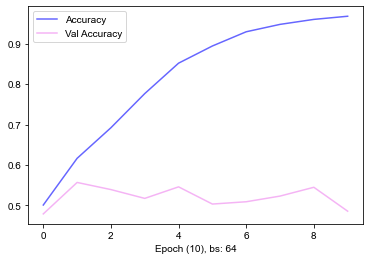

In [27]:
plt.clf()
plt.plot(metrics3["accuracy"], c="blue", label="Accuracy", alpha=0.6)
plt.plot(metrics3["val_accuracy"], c="violet", label="Val Accuracy", alpha=0.6)
plt.xlabel(f"Epoch ({epochs}), bs: {batch_size}")
plt.legend()
plt.show()

In [ ]:
model, params = fit_mini_rocket()

In [ ]:
pred = model.predict(MiniRocket.transform(X_te.astype("float32"), params))

print(model.score(MiniRocket.transform(X_tr.astype("float32"), params), Y_tr.astype("float32")))
print(model.score(MiniRocket.transform(X_te.astype("float32"), params), Y_te.astype("float32")))

In [ ]:
pred = model.predict(MiniRocket.transform(X_te.astype("float32"), params))

In [ ]:
m = tf.keras.metrics.AUC(multi_label=True, thresholds=[0, 0.5])
m(Y_te, pred).numpy()

In [ ]:
total = 0
pred = model.predict(MiniRocket.transform(X_te.astype("float32"), params))
for i in range(len(pred)):
  # Bug workaround
  total += 1 if accuracy_score(pred[i], Y_te[i]) == 1.0 else 0
  
print(total/len(X_te))